Задача 
- реализовать один из алгоритмов RL (рекомендуем Q-learning, a.k.a. SARSAMAX);
- реализовать логику обучения агента используя среду из Gymnasium;
- решить задачу Taxi-v3;
- сделать небольшой отчет об обучении агента (графики награды).
- расчитывайте суммарную награду и среднюю награду за последние 100 эпизодов;
- результат должен содержать исходный код агента, сохраненного агента, графики награды в процессе обучения агента.


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# Создаем окружение Taxi
env = gym.make('Taxi-v3')

In [3]:
# Устанавливаем параметры Q-learning
num_episodes = 600         # Всего эпизодов для обучения
max_steps = 200             # Максимальное количество шагов в эпизоде
learning_rate = 0.1         # Скорость обучения
discount_factor = 0.99      # Ставка дисконтировнаия
exploration_rate = 1.0      # Исходный коэффициент для эпсилон жадной статегии
max_exploration_rate = 1.0  # Верхний предел эпсилон-жадной стратегии 
min_exploration_rate = 0.01 # Нижний предел эпсилон-жадной стратегии 
decay_rate = 0.01           # Скорость уменьшения epsilon

In [4]:
# Определяем размер пространства состояний окружающей среды
state_space_size = env.observation_space.n
# Определяем количество возможных действий в пространстве действий
action_space_size = env.action_space.n
# Создаем Q-таблицу, инициализированную нулями, где строки соответствуют состояниям,
# а столбцы – действиям. Размер таблицы определяется количеством состояний и действий.
q_table = np.zeros((state_space_size, action_space_size))
# Создаем список для хранения полученных вознаграждений за каждый эпизод
reward_list = []
# Создаем список для хранения среднего вознаграждения за несколько эпизодов
average_reward_list = []



In [5]:
# Обучение агента
for episode in range(num_episodes):
    state = env.reset()[0]  # Обнуляем среду и получаем исходной состояние
    total_reward = 0  # Суммарное вознаграждение за эпизод

    for step in range(max_steps):
        # Решение о действии с использованием эппсилон-жадной стратегии
        exploration_rate_threshold = np.random.rand()
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state, :])  # Действие с максимальным Q-значением  
        else:
            action = env.action_space.sample()  # Случайное действие

        # Применяем действие и получаем новое состояние и вознаграждение
        next_state, reward, done, _, _ = env.step(action)
        
        # Обновляем Q-таблицу
        q_table[state, action] = q_table[state, action] + learning_rate * (reward + discount_factor * np.max(q_table[next_state, :]) - q_table[state, action])
        
        total_reward += reward  # Увеличиваем общее вознаграждение
        state = next_state  # Переходим к следующему состоянию
        
        if done:  # Если эпизод завершен, выходим из цикла
            break

    # Сохраняем награду за эпизод и обновляем эпсилон
    reward_list.append(total_reward)
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-decay_rate * episode)

    # Рассчитываем среднюю оценку за последние 100 эпизодов
    if episode >= 500:
        average_reward = np.mean(reward_list[-100:])
        average_reward_list.append(average_reward)


In [10]:
# Сохранение обученной модели
model_data = {
    "q_table": q_table,
    "reward_list": reward_list,
    "average_reward_list": average_reward_list,
    "num_episodes": num_episodes,
    "max_steps": max_steps,
    "learning_rate": learning_rate,
    "discount_factor": discount_factor,
    "exploration_rate": exploration_rate,
    "max_exploration_rate": max_exploration_rate,
    "min_exploration_rate": min_exploration_rate,
    "decay_rate": decay_rate
}
with open("taxi_trained_model_base.pkl", "wb") as f:
    pickle.dump(model_data, f)

C:\Users\User\AppData\Local\Temp\ipykernel_7600\3552797833.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


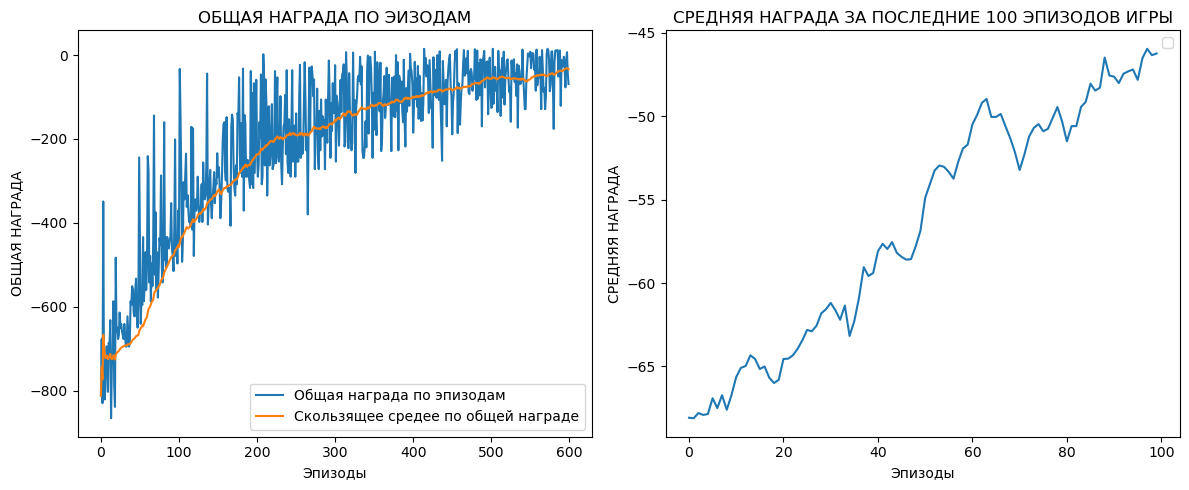

In [11]:
# Вычисление скользящей средней общей награды
smoothed_rewards = []
smoothing_window = 50  # Окно сглаживания 

for i in range(len(reward_list)):
    if i < smoothing_window:
        smoothed_rewards.append(np.mean(reward_list[:i+1]))  # Среднее значение за первые n эпизодов окна
    else:
        smoothed_rewards.append(np.mean(reward_list[i-smoothing_window:i+1]))  # Скользящая средняя

# Вывод на график
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reward_list, label='Общая награда по эпизодам')
plt.plot(smoothed_rewards, label='Скользящее средее по общей награде')
plt.title('ОБЩАЯ НАГРАДА ПО ЭИЗОДАМ')
plt.xlabel('Эпизоды')
plt.ylabel('ОБЩАЯ НАГРАДА')
plt.legend(loc='best')  # Легенду в наиболее удачном месте

plt.subplot(1, 2, 2)
plt.plot(average_reward_list)
plt.title('СРЕДНЯЯ НАГРАДА ЗА ПОСЛЕДНИЕ 100 ЭПИЗОДОВ ИГРЫ')
plt.xlabel('Эпизоды')
plt.ylabel('СРЕДНЯЯ НАГРАДА')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [12]:
# Попробуем затюнить гиперпараметры Q-леарнинга
import optuna

In [13]:
# Функция для обучения агента с заданными параметрами
def train_agent(trial):
    num_episodes = trial.suggest_int("num_episodes", 300, 1200)
    max_steps = trial.suggest_int("max_steps", 50, 250)
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.25)
    discount_factor = trial.suggest_uniform("discount_factor", 0.8, 0.999)
    decay_rate = trial.suggest_loguniform("decay_rate", 1e-3, 1e-1)

    env = gym.make('Taxi-v3')  
    state_space_size = env.observation_space.n
    action_space_size = env.action_space.n
    q_table = np.zeros((state_space_size, action_space_size))
    reward_list = []
    average_reward_list = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0

        for step in range(max_steps):
            exploration_rate_threshold = np.random.rand()
            exploration_rate = trial.suggest_uniform("exploration_rate", 0.01, 1.0)
            if exploration_rate_threshold > exploration_rate:
                action = np.argmax(q_table[state, :])
            else:
                action = env.action_space.sample()

            next_state, reward, done, _, _ = env.step(action)
            q_table[state, action] = q_table[state, action] + learning_rate * (
                    reward + discount_factor * np.max(q_table[next_state, :]) - q_table[state, action])

            total_reward += reward
            state = next_state

            if done:
                break

        reward_list.append(total_reward)
        exploration_rate *= np.exp(-decay_rate * episode)

        if episode >= 500:
            average_reward = np.mean(reward_list[-100:])
            average_reward_list.append(average_reward)

    # Возвращаем среднее вознаграждение за последние 100 эпизодов
    return np.mean(average_reward_list)


In [14]:
# Оптимизация гиперпараметров с использованием Optuna
# Оптунить будем на 100 экспериментах, это довольно долгло на ЦПУ. 
# Кроме того есть вероятность получать "нановые" ответы и провалыц  при неудачных сочетаниях. Надо подбирать границы 
#В RL модели все-таки нужно тюнить по другому. Использую опыт тюнинга обычных ансамблевых моделей ML
# Фиксацию случайности не делаем, но итоговые гиперпараметры выведем
study = optuna.create_study(direction='maximize')
study.optimize(train_agent, n_trials=100)

[I 2025-01-26 20:40:39,272] A new study created in memory with name: no-name-bb1a0236-0377-43d3-8a9b-46107960cbc5
C:\Users\User\AppData\Local\Temp\ipykernel_7600\2121162193.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  discount_factor = trial.suggest_uniform("discount_factor", 0.8, 0.999)
C:\Users\User\AppData\Local\Temp\ipykernel_7600\2121162193.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  decay_rate = trial.suggest_loguniform("decay_rate", 1e-3, 1e-1)
C:\Users\User\AppData\Local\Temp\ipykernel_7600\2121162193.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

In [23]:
# Получаем лучшие гиперпараметры
best_params = study.best_params
print(f'Лучшие гиперпараметры: {best_params}')

Лучшие гиперпараметры: {'num_episodes': 1195, 'max_steps': 143, 'learning_rate': 0.24069717437034951, 'discount_factor': 0.8513618266540847, 'decay_rate': 0.0016724679640988862, 'exploration_rate': 0.014429419340899863}


In [ ]:
#Лучшие гиперпараметры: {'num_episodes': 1152, 'max_steps': 118, 'learning_rate': 0.243331727785434, 'discount_factor': 0.8179419714676264, 
#'decay_rate': 0.02076520828562183, 'exploration_rate': 0.17347302248642935}

In [25]:
# Создаем окружение Taxi
env = gym.make('Taxi-v3')

In [27]:
# Устанавливаем параметры Q-learning
num_episodes = 1195        # Всего эпизодов для обучения
max_steps = 143           # Максимальное количество шагов в эпизоде
learning_rate = 0.24069717437034951       # Скорость обучения
discount_factor = 0.8513618266540847   # Cтавка дисконтирования
exploration_rate = 0.014429419340899863    # Исходный коэффициент для эпсилон жадной стратегии
max_exploration_rate = 0.04               # Ограничим верхний предел
min_exploration_rate = 0.01               # Ограничим нижний предел
decay_rate = 0.0016724679640988862        # Скорость уменьшения эплилона

In [37]:
# Инициализируем Q-таблицу
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
q_table = np.zeros((state_space_size, action_space_size))
# Списки для хранения наград
reward_list = []
average_reward_list = []

In [39]:
# Обучение агента
for episode in range(num_episodes):
    state = env.reset()[0]  # Сбрасываем среду и получаем начальное состояние
    total_reward = 0  # Суммарное вознаграждение за эпизод

    for step in range(max_steps):
        # Решение о действии с использованием экпилон-жадной стратегии
        exploration_rate_threshold = np.random.rand()
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state, :])  # Действие с максимальным Q-значением
        else:
            action = env.action_space.sample()  # Случайное действие

        # Применяем действие и получаем новое состояние и вознаграждение
        next_state, reward, done, _, _ = env.step(action)
        
        # Обновляем Q-таблицу
        q_table[state, action] = q_table[state, action] + learning_rate * (reward + discount_factor * np.max(q_table[next_state, :]) - q_table[state, action])
        
        total_reward += reward  # Увеличиваем общее вознаграждение
        state = next_state  # Переходим к следующему состоянию
        
        if done:  # Если эпизод завершен, выходим из цикла
            break

    # Сохраняем награду за эпизод и обновляем epsilon
    reward_list.append(total_reward)
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-decay_rate * episode)

    # Рассчитываем среднюю оценку за последние 100 эпизодов
    if episode >= 404:
        average_reward = np.mean(reward_list[-100:])
        average_reward_list.append(average_reward)

In [40]:
# Сохранение заоптюненой  модели
model_data = {
    "q_table": q_table,
    "reward_list": reward_list,
    "average_reward_list": average_reward_list,
    "num_episodes": num_episodes,
    "max_steps": max_steps,
    "learning_rate": learning_rate,
    "discount_factor": discount_factor,
    "exploration_rate": exploration_rate,
    "max_exploration_rate": max_exploration_rate,
    "min_exploration_rate": min_exploration_rate,
    "decay_rate": decay_rate
}
with open("taxi_trained_model_optuned.pkl", "wb") as f:
    pickle.dump(model_data, f)

C:\Users\User\AppData\Local\Temp\ipykernel_7600\3585515234.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


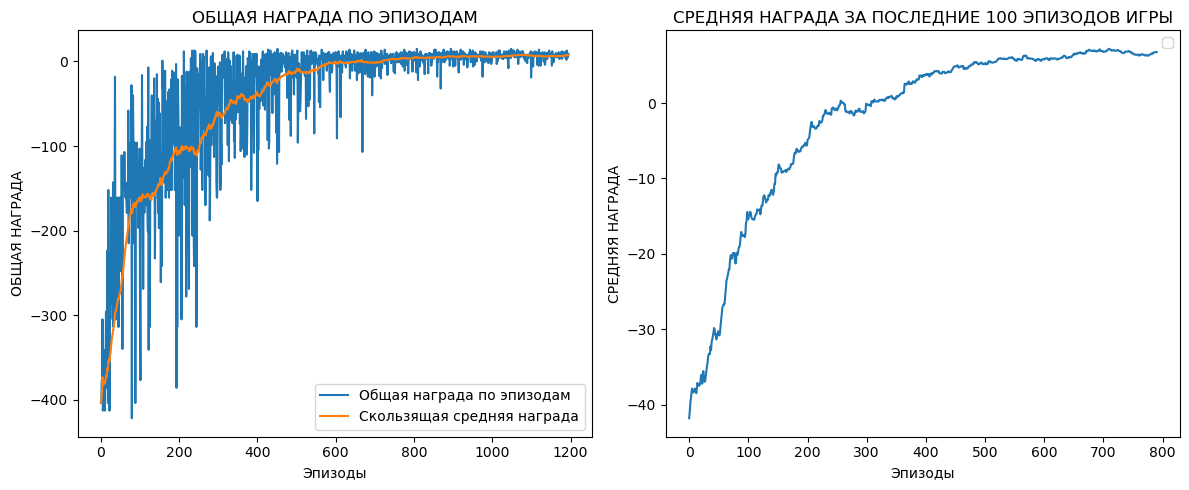

In [41]:
# Вычисление скользящей средней общей награды
smoothed_rewards = []
smoothing_window = 50  # Окно скользящего среднего

for i in range(len(reward_list)):
    if i < smoothing_window:
        smoothed_rewards.append(np.mean(reward_list[:i+1]))  # Среднее значение за первые n эпизодов
    else:
        smoothed_rewards.append(np.mean(reward_list[i-smoothing_window:i+1]))  # Скользящее средняя

# Вывод 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reward_list, label='Общая награда по эпизодам')
plt.plot(smoothed_rewards, label='Скользящая средняя награда')
plt.title('ОБЩАЯ НАГРАДА ПО ЭПИЗОДАМ')
plt.xlabel('Эпизоды')
plt.ylabel('ОБЩАЯ НАГРАДА')
plt.legend(loc='best')  # Легенда 

plt.subplot(1, 2, 2)
plt.plot(average_reward_list)
plt.title('СРЕДНЯЯ НАГРАДА ЗА ПОСЛЕДНИЕ 100 ЭПИЗОДОВ ИГРЫ')
plt.xlabel('Эпизоды')
plt.ylabel('СРЕДНЯЯ НАГРАДА')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [45]:
#Теперь решим задачу с помощью нейросети 

In [47]:
import torch
import torch.nn as nn
import torch.optim as optimizer
from tqdm import tqdm
import matplotlib.pyplot as plt

In [48]:
# Создание нейронной сети в лоб - без подбора параметров
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [51]:
# Создаем окружение Taxi
env = gym.make('Taxi-v3')

# Параметры
num_episodes = 300
max_steps = 200
learning_rate = 0.001
discount_factor = 0.99
exploration_rate = 1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.01
decay_rate = 0.001


In [53]:
def one_hot_encode(state, size):
    vector = np.zeros(size)
    vector[state] = 1
    return vector

In [55]:
# Инициализация сети и оптимизатора
state_size = env.observation_space.n
action_size = env.action_space.n
q_network = QNetwork(state_size, action_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(q_network.parameters(), lr=learning_rate)

# Списки для хранения наград
reward_list = []
average_reward_list = []


In [56]:
# Обучение агента
for episode in tqdm(range(num_episodes), desc="Поцесс обучения"):
    state = env.reset()[0]
    total_reward = 0

    for step in range(max_steps):
       # Решение о действии с использованием epsilon-greedy стратегии
        exploration_rate_threshold = np.random.rand()
        if exploration_rate_threshold > exploration_rate:
            state_onehot = one_hot_encode(state, state_size)
            state_tensor = torch.tensor([state_onehot], dtype=torch.float32)
            action = torch.argmax(q_network(state_tensor)).item()  # Действие с максимальным Q-значением
        else:
            action = env.action_space.sample()  # Случайное действие

        # Применение действия и получение нового состояния и вознаграждения
        next_state, reward, done, _, _ = env.step(action)
        
       # Входные данные для обновления Q-значений
        state_onehot = one_hot_encode(state, state_size)
        state_tensor = torch.tensor([state_onehot], dtype=torch.float32)
        next_state_onehot = one_hot_encode(next_state, state_size)
        next_state_tensor = torch.tensor([next_state_onehot], dtype=torch.float32)
        
        # Изменяем строку для правильного расчета target
        next_state_values = q_network(next_state_tensor)
        target = reward + (discount_factor * torch.max(next_state_values).item() * (1 - int(done)))

        # Получение текущих Q-значений
        target_f = q_network(state_tensor).detach()  # Отключаем градиенты для целевых значений
        target_f[0][action] = target
        
        # Обучение нейронной сети
        optimizer.zero_grad()
        loss = criterion(q_network(state_tensor), target_f)
        loss.backward()
        optimizer.step()

        total_reward += reward
        state = next_state

        if done:  # Если эпизод завершен, выходим из цикла
            break

    # Сохраняем награду за эпизод и обновляем epsilon
    reward_list.append(total_reward)
    exploration_rate = max(min_exploration_rate, exploration_rate * np.exp(-decay_rate * episode))
    # Рассчитываем среднюю оценку за последние 100 эпизодов
    if episode >= 200:
        average_reward = np.mean(reward_list[-100:])
        average_reward_list.append(average_reward)

# Сохранение модели после обучения
torch.save(q_network.state_dict(), 'taxi_trained_model_dict.pt')  # Сохраняет только параметры модели
torch.save(q_network, 'taxi_full_trained_model.pth')  # Полностью сохраняет модель

Поцесс обучения:   0%|                                                                         | 0/300 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_7600\4088662502.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  state_tensor = torch.tensor([state_onehot], dtype=torch.float32)
Поцесс обучения: 100%|███████████████████████████████████████████████████████████████| 300/300 [03:18<00:00,  1.51it/s]


C:\Users\User\AppData\Local\Temp\ipykernel_7600\2343575698.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


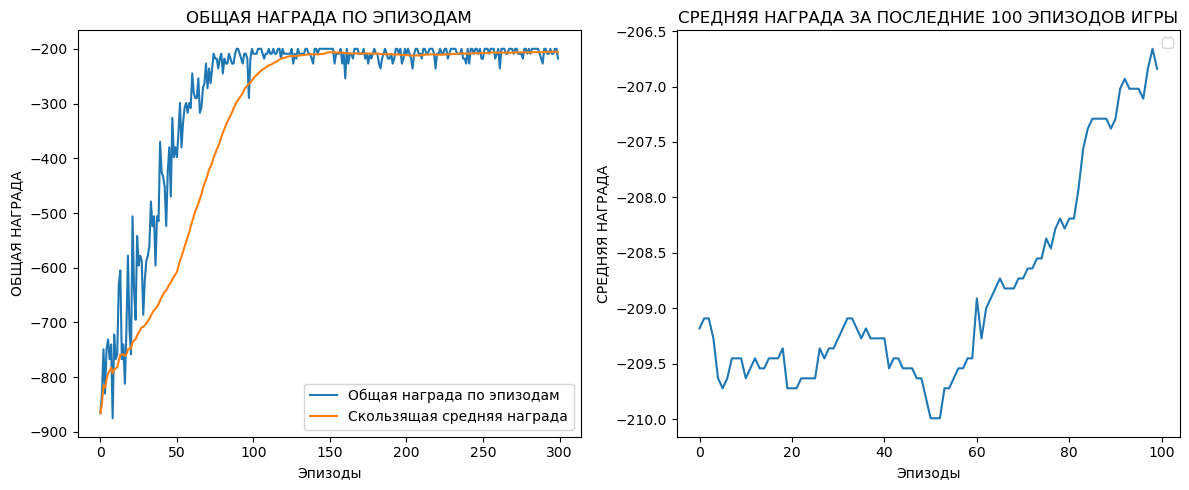

In [61]:
# Вычисление скользящей средней общей награды
smoothed_rewards = []
smoothing_window = 50  # Окно сглаживания (можно выбрать любое подходящее окно)

for i in range(len(reward_list)):
    if i < smoothing_window:
        smoothed_rewards.append(np.mean(reward_list[:i+1]))  # Среднее значение за первые n эпизодов
    else:
        smoothed_rewards.append(np.mean(reward_list[i-smoothing_window:i+1]))  # Скользящая средняя

# Вывод на график
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reward_list, label='Общая награда по эпизодам')
plt.plot(smoothed_rewards, label='Скользящая средняя награда')
plt.title('ОБЩАЯ НАГРАДА ПО ЭПИЗОДАМ')
plt.xlabel('Эпизоды')
plt.ylabel('ОБЩАЯ НАГРАДА')
plt.legend(loc='best')  # Легенда расположена в лучшем месте

plt.subplot(1, 2, 2)
plt.plot(average_reward_list)
plt.title('СРЕДНЯЯ НАГРАДА ЗА ПОСЛЕДНИЕ 100 ЭПИЗОДОВ ИГРЫ')
plt.xlabel('Эпизоды')
plt.ylabel('СРЕДНЯЯ НАГРАДА')
plt.legend(loc='best')

plt.tight_layout()
plt.show()